In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

import requests
from bs4 import BeautifulSoup
from io import StringIO

from data.omni import OMNI
from data.wsa_enlil import WSA_ENLIL
from data.eswf3_2 import ESWF3_2
from data.dl_model import DL_Model

from scipy.stats import pearsonr

import skill_metrics as sm
from matplotlib import rcParams

#CR_file_path = "E:/research/SW_Speed_Models_Comparison/data/Carrington_Rotation_Data__Oct-Dec__2010-2020_.csv"
#CR_df = pd.read_csv(CR_file_path)

## ICME Events

In [2]:
# ICME event list URL
ICME_url = "https://izw1.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm"

# URL에서 HTML 페이지 가져오기
response = requests.get(ICME_url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')
    icme_entire_table = pd.read_html(StringIO(str(table)))[0]
    
    # 열 선택 (ICME_start, ICME_end, ICME_mean, ICME_max)
    icme_sub_table = icme_entire_table.iloc[:, [1, 2, 11, 12]]
    new_column_names = ['ICME_start', 'ICME_end', 'ICME_mean', 'ICME_max']  # column 이름 설정
    icme_sub_table.columns = new_column_names
    icme_sub_table = icme_sub_table.dropna(subset=['ICME_start', 'ICME_end'])  # NaN 제거

    # datetime format
    icme_sub_table['ICME_start'] = pd.to_datetime(icme_sub_table['ICME_start'], errors='coerce', format='%Y/%m/%d %H%M')
    icme_sub_table['ICME_end'] = pd.to_datetime(icme_sub_table['ICME_end'], errors='coerce', format='%Y/%m/%d %H%M')

    # filtering (Oct-Dec, 2012, 2020)
    filtered_icme_df = icme_sub_table[
        (icme_sub_table['ICME_start'].dt.year >= 2012) & 
        (icme_sub_table['ICME_start'].dt.year <= 2020) & 
        (icme_sub_table['ICME_start'].dt.month >= 10) & 
        (icme_sub_table['ICME_start'].dt.month <= 12) & 
        (icme_sub_table['ICME_end'].dt.year >= 2012) & 
        (icme_sub_table['ICME_end'].dt.year <= 2020) & 
        (icme_sub_table['ICME_end'].dt.month >= 10) & 
        (icme_sub_table['ICME_end'].dt.month <= 12)
    ]
    filtered_icme_df.reset_index(drop=True, inplace=True)
    icme_df = filtered_icme_df
    
else:
    print(f"Request failed with status code: {response.status_code}")
    
icme_event_list = []

for i in range(len(icme_df['ICME_start'])):
    ICME_event = [
        icme_df['ICME_start'][i].strftime('%Y-%m-%d %H:%M'), 
        icme_df['ICME_end'][i].strftime('%Y-%m-%d %H:%M')
    ]
    icme_event_list.append(ICME_event)

#icme_event_list=icme_event_list[2:] # DL model에 없는 날짜 제거
print("Number of the ICME events:", len(icme_event_list))
icme_event_list

Number of the ICME events: 32


[['2012-10-01 00:00', '2012-10-02 00:00'],
 ['2012-10-02 22:00', '2012-10-03 06:00'],
 ['2012-10-08 18:00', '2012-10-09 12:00'],
 ['2012-10-12 22:00', '2012-10-13 10:00'],
 ['2012-11-01 00:00', '2012-11-02 03:00'],
 ['2012-11-09 03:00', '2012-11-09 15:00'],
 ['2012-11-13 08:00', '2012-11-14 03:00'],
 ['2012-11-24 12:00', '2012-11-25 10:00'],
 ['2012-11-26 12:00', '2012-11-28 05:00'],
 ['2012-11-28 18:00', '2012-11-29 14:00'],
 ['2012-12-14 07:00', '2012-12-14 17:00'],
 ['2013-10-02 23:00', '2013-10-03 22:00'],
 ['2013-10-09 09:00', '2013-10-11 00:00'],
 ['2013-11-08 22:00', '2013-11-09 07:00'],
 ['2013-11-11 17:00', '2013-11-12 03:00'],
 ['2013-12-01 11:00', '2013-12-02 23:00'],
 ['2013-12-15 16:00', '2013-12-16 05:00'],
 ['2013-12-25 05:00', '2013-12-25 17:00'],
 ['2014-11-11 07:00', '2014-11-11 20:00'],
 ['2014-12-22 04:00', '2014-12-22 17:00'],
 ['2015-10-25 14:00', '2015-10-27 04:00'],
 ['2015-11-04 15:00', '2015-11-04 19:00'],
 ['2015-11-07 06:00', '2015-11-08 16:00'],
 ['2015-12-

---

## Statistical Verification

### MAE

In [3]:
all_CR_list = [2128, 2129, 2130, 2131, 2132,
               2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158, 
               2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212, 
               2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

ascending_CR_list = [2128, 2129, 2130, 2131, 2132]
maximum_CR_list = [2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158]
descending_CR_list = [2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212]
minimum_CR_list = [2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

model_mae = 0
wsa_mae = 0
eswf_mae = 0

model_n = 0
wsa_n = 0
eswf_n = 0

def MAE(omni, model, valid_index):
    omni = np.array(omni)
    model = np.array(model)
    
    errors = omni[valid_index] - model[valid_index]
    error_sum = np.sum(np.abs(errors))
    n = len(errors)
    return error_sum, n

for CR_lists in [all_CR_list, ascending_CR_list, maximum_CR_list, descending_CR_list, minimum_CR_list]:
    for CR in tqdm(CR_lists):
        _, omni_speeds = OMNI(CR)
        _, wsa_speeds = WSA_ENLIL(CR)
        _, eswf3_2speeds = ESWF3_2(CR)
        _, model_speeds = DL_Model(CR)
    
        valid_index = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)
    
        # 사용자 모델에 대한 MAE 계산
        model_error_sum, model_count = MAE(omni_speeds, model_speeds, valid_index)
        model_mae += model_error_sum
        model_n += model_count
        
        # WSA 모델에 대한 MAE 계산
        wsa_error_sum, wsa_count = MAE(omni_speeds, wsa_speeds, valid_index)
        wsa_mae += wsa_error_sum
        wsa_n += wsa_count
    
        # ESWF3_2 모델에 대한 MAE 계산
        eswf_error_sum, eswf_count = MAE(omni_speeds, eswf3_2speeds, valid_index)
        eswf_mae += eswf_error_sum
        eswf_n += eswf_count

        #print(np.round(model_error_sum/model_count, 4))

    print("model: {} km/s".format(np.round(model_mae/model_n, 4)))
    print("wsa: {} km/s".format(np.round(wsa_mae/wsa_n, 1)))
    print("eswf: {} km/s".format(np.round(eswf_mae/eswf_n, 1)), '\n')

    model_mae, wsa_mae, eswf_mae = 0, 0, 0
    model_n, wsa_n, eswf_n = 0, 0, 0

100%|██████████| 40/40 [02:44<00:00,  4.11s/it]


model: 51.4301 km/s
wsa: 86.9 km/s
eswf: 100.4 km/s 



100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


model: 57.5888 km/s
wsa: 67.7 km/s
eswf: 74.5 km/s 



100%|██████████| 8/8 [00:36<00:00,  4.54s/it]


model: 60.529 km/s
wsa: 98.0 km/s
eswf: 91.5 km/s 



100%|██████████| 18/18 [01:12<00:00,  4.03s/it]


model: 50.9593 km/s
wsa: 86.2 km/s
eswf: 117.4 km/s 



100%|██████████| 9/9 [00:36<00:00,  4.01s/it]

model: 41.7413 km/s
wsa: 86.8 km/s
eswf: 86.5 km/s 



### RMSE

In [4]:
all_CR_list = [2128, 2129, 2130, 2131, 2132,
               2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158, 
               2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212, 
               2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

ascending_CR_list = [2128, 2129, 2130, 2131, 2132]
maximum_CR_list = [2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158]
descending_CR_list = [2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212]
minimum_CR_list = [2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

model_mse = 0
wsa_mse = 0
eswf_mse = 0

model_n = 0
wsa_n = 0
eswf_n = 0

def MSE(omni, model, valid_index):
    omni = np.array(omni)
    model = np.array(model)
    
    errors = omni[valid_index] - model[valid_index]
    error_sum = np.sum(errors ** 2)
    n = len(errors)
    return error_sum, n

for CR_lists in [all_CR_list, ascending_CR_list, maximum_CR_list, descending_CR_list, minimum_CR_list]:
    for CR in tqdm(CR_lists):
        _, omni_speeds = OMNI(CR)
        _, wsa_speeds = WSA_ENLIL(CR)
        _, eswf3_2speeds = ESWF3_2(CR)
        _, model_speeds = DL_Model(CR)
        
        valid_index = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)
        
        # 사용자 모델에 대한 MSE 계산
        model_error_sum, model_count = MSE(omni_speeds, model_speeds, valid_index)
        model_mse += model_error_sum
        model_n += model_count
        
        # WSA 모델에 대한 MSE 계산
        wsa_error_sum, wsa_count = MSE(omni_speeds, wsa_speeds, valid_index)
        wsa_mse += wsa_error_sum
        wsa_n += wsa_count
    
        # ESWF3_2 모델에 대한 MSE 계산
        eswf_error_sum, eswf_count = MSE(omni_speeds, eswf3_2speeds, valid_index)
        eswf_mse += eswf_error_sum
        eswf_n += eswf_count

        #print(np.round(np.sqrt(model_error_sum/model_count), 4))
    
    # RMSE 계산
    print("model: {} km/s".format(np.round(np.sqrt(model_mse/model_n), 4)))
    print("wsa: {} km/s".format(np.round(np.sqrt(wsa_mse/wsa_n), 1)))
    print("eswf: {} km/s".format(np.round(np.sqrt(eswf_mse/eswf_n), 1)), '\n')

    model_mse, wsa_mse, eswf_mse = 0, 0, 0
    model_n, wsa_n, eswf_n = 0, 0, 0

100%|██████████| 40/40 [02:42<00:00,  4.07s/it]


model: 68.5605 km/s
wsa: 116.3 km/s
eswf: 130.9 km/s 



100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


model: 67.3133 km/s
wsa: 92.9 km/s
eswf: 94.9 km/s 



100%|██████████| 8/8 [00:35<00:00,  4.47s/it]


model: 83.3058 km/s
wsa: 119.2 km/s
eswf: 122.2 km/s 



100%|██████████| 18/18 [01:12<00:00,  4.04s/it]


model: 66.2128 km/s
wsa: 114.8 km/s
eswf: 147.8 km/s 



100%|██████████| 9/9 [00:36<00:00,  4.01s/it]

model: 58.5773 km/s
wsa: 125.7 km/s
eswf: 116.1 km/s 



### PCC

In [5]:
all_CR_list = [2128, 2129, 2130, 2131, 2132,
               2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158, 
               2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212, 
               2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

ascending_CR_list = [2128, 2129, 2130, 2131, 2132]
maximum_CR_list = [2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158]
descending_CR_list = [2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212]
minimum_CR_list = [2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

wsa_omni_valid = []
wsa_model_valid = []

eswf_omni_valid = []
eswf_model_valid = []

model_omni_valid = []
model_model_valid = []

for CR_lists in [all_CR_list, ascending_CR_list, maximum_CR_list, descending_CR_list, minimum_CR_list]:
    for CR in tqdm(CR_lists):
        _, omni_speeds = OMNI(CR)
        _, wsa_speeds = WSA_ENLIL(CR)
        _, eswf3_2speeds = ESWF3_2(CR)
        _, model_speeds = DL_Model(CR)
        
        omni_speeds = np.array(omni_speeds)
        wsa_speeds = np.array(wsa_speeds)
        eswf3_2speeds = np.array(eswf3_2speeds)
        model_speeds = np.array(model_speeds)
    
        valid_index = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)
        
        # 사용자 모델에 대한 유효한 데이터 수집
        model_omni_valid.extend(omni_speeds[valid_index])
        model_model_valid.extend(model_speeds[valid_index])
        
        # WSA 모델에 대한 유효한 데이터 수집
        wsa_omni_valid.extend(omni_speeds[valid_index])
        wsa_model_valid.extend(wsa_speeds[valid_index])
        
        # ESWF3_2 모델에 대한 유효한 데이터 수집
        eswf_omni_valid.extend(omni_speeds[valid_index])
        eswf_model_valid.extend(eswf3_2speeds[valid_index])
        
    model_pcc, _ = pearsonr(model_omni_valid, model_model_valid)
    wsa_pcc, _ = pearsonr(wsa_omni_valid, wsa_model_valid)
    eswf_pcc, _ = pearsonr(eswf_omni_valid, eswf_model_valid)
    
    # PCC 계산
    print("model PCC: {}".format(np.round(model_pcc, 4)))
    print("wsa PCC: {}".format(np.round(wsa_pcc, 2)))
    print("eswf PCC: {}".format(np.round(eswf_pcc, 2)), '\n')
    
    wsa_omni_valid = []
    wsa_model_valid = []

    eswf_omni_valid = []
    eswf_model_valid = []

    model_omni_valid = []
    model_model_valid = []

100%|██████████| 40/40 [02:43<00:00,  4.08s/it]


model PCC: 0.6881
wsa PCC: 0.41
eswf PCC: 0.08 



100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


model PCC: 0.4902
wsa PCC: 0.35
eswf PCC: 0.12 



100%|██████████| 8/8 [00:35<00:00,  4.47s/it]


model PCC: 0.3514
wsa PCC: 0.37
eswf PCC: 0.19 



100%|██████████| 18/18 [01:12<00:00,  4.00s/it]


model PCC: 0.771
wsa PCC: 0.49
eswf PCC: -0.02 



100%|██████████| 9/9 [00:35<00:00,  4.00s/it]

model PCC: 0.6527
wsa PCC: 0.24
eswf PCC: -0.09 



In [6]:
CR_list_2012 = [2128, 2129, 2130, 2131, 2132]
CR_list_2013 = [2142, 2143, 2144, 2145]
CR_list_2014 = [2155, 2156, 2157, 2158]
CR_list_2015 = [2168, 2169, 2170, 2171, 2172]
CR_list_2016 = [2182, 2183, 2184, 2185]
CR_list_2017 = [2195, 2196, 2197, 2198, 2199]
CR_list_2018 = [2209, 2210, 2211, 2212]
CR_list_2019 = [2222, 2223, 2224, 2225]
CR_list_2020 = [2235, 2236, 2237, 2238, 2239]
omni_valid, model_valid, wsa_valid, eswf_valid = [], [], [], []

for CR_lists in [CR_list_2012, CR_list_2013, CR_list_2014, CR_list_2015, CR_list_2016, CR_list_2017, CR_list_2018, CR_list_2019, CR_list_2020]:
    print("{}".format(CR_lists))
    for CR in tqdm(CR_lists):
        _, omni_speeds = OMNI(CR)
        _, wsa_speeds = WSA_ENLIL(CR)
        _, eswf3_2speeds = ESWF3_2(CR)
        _, model_speeds = DL_Model(CR)
        
        omni_speeds = np.array(omni_speeds)
        wsa_speeds = np.array(wsa_speeds)
        eswf3_2speeds = np.array(eswf3_2speeds)
        model_speeds = np.array(model_speeds)
    
        valid_index = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)

        omni_valid.extend(omni_speeds[valid_index])
        model_valid.extend(model_speeds[valid_index])
        wsa_valid.extend(wsa_speeds[valid_index])
        eswf_valid.extend(eswf3_2speeds[valid_index])
        
    model_pcc, _ = pearsonr(omni_valid, model_valid)
    wsa_pcc, _ = pearsonr(omni_valid, wsa_valid)
    eswf_pcc, _ = pearsonr(omni_valid, eswf_valid)
    
    # PCC 계산
    print("model PCC: {}".format(np.round(model_pcc, 2)))
    print("wsa PCC: {}".format(np.round(wsa_pcc, 2)))
    print("eswf PCC: {}".format(np.round(eswf_pcc, 2)), '\n')
    
    omni_valid, model_valid, wsa_valid, eswf_valid = [], [], [], []

[2128, 2129, 2130, 2131, 2132]


100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


model PCC: 0.49
wsa PCC: 0.35
eswf PCC: 0.12 

[2142, 2143, 2144, 2145]


100%|██████████| 4/4 [00:18<00:00,  4.51s/it]


model PCC: 0.35
wsa PCC: 0.18
eswf PCC: -0.01 

[2155, 2156, 2157, 2158]


100%|██████████| 4/4 [00:17<00:00,  4.50s/it]


model PCC: 0.44
wsa PCC: 0.23
eswf PCC: 0.02 

[2168, 2169, 2170, 2171, 2172]


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


model PCC: 0.76
wsa PCC: 0.45
eswf PCC: 0.27 

[2182, 2183, 2184, 2185]


100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


model PCC: 0.86
wsa PCC: 0.69
eswf PCC: -0.15 

[2195, 2196, 2197, 2198, 2199]


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


model PCC: 0.76
wsa PCC: 0.39
eswf PCC: -0.19 

[2209, 2210, 2211, 2212]


100%|██████████| 4/4 [00:18<00:00,  4.65s/it]


model PCC: 0.71
wsa PCC: 0.33
eswf PCC: -0.12 

[2222, 2223, 2224, 2225]


100%|██████████| 4/4 [00:18<00:00,  4.51s/it]


model PCC: 0.7
wsa PCC: 0.28
eswf PCC: 0.09 

[2235, 2236, 2237, 2238, 2239]


100%|██████████| 5/5 [00:17<00:00,  3.55s/it]

model PCC: 0.66
wsa PCC: 0.25
eswf PCC: -0.21 



In [7]:
# CR 데이터
all_CR_list = [2128, 2129, 2130, 2131, 2132, 2142, 2143, 2144, 2145, 
               2155, 2156, 2157, 2158, 2168, 2169, 2170, 2171, 2172, 
               2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 
               2209, 2210, 2211, 2212, 2222, 2223, 2224, 2225, 2235, 
               2236, 2237, 2238, 2239]

# 모든 데이터를 저장할 리스트
all_omni = []
all_model = []
all_wsa = []
all_eswf = []

# CR 리스트
ascending_CR_list = [2128, 2129, 2130, 2131, 2132]
maximum_CR_list = [2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158]
descending_CR_list = [2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212]
minimum_CR_list = [2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

# 새로운 리스트 초기화
ascending_omni, ascending_model, ascending_wsa, ascending_eswf = [], [], [], []
maximum_omni, maximum_model, maximum_wsa, maximum_eswf = [], [], [], []
descending_omni, descending_model, descending_wsa, descending_eswf = [], [], [], []
minimum_omni, minimum_model, minimum_wsa, minimum_eswf = [], [], [], []

# 데이터 처리 및 분류
for CR in tqdm(all_CR_list):
    # 데이터 수집
    _, omni_speeds = OMNI(CR)
    _, model_speeds = DL_Model(CR)
    _, wsa_speeds = WSA_ENLIL(CR)
    _, eswf3_2speeds = ESWF3_2(CR)

    # 데이터 필터링 (NaN 제거)
    omni_speeds = np.array(omni_speeds)
    model_speeds = np.array(model_speeds)
    wsa_speeds = np.array(wsa_speeds)
    eswf3_2speeds = np.array(eswf3_2speeds)

    valid_index = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)

    omni_speeds = omni_speeds[valid_index]
    model_speeds = model_speeds[valid_index]
    wsa_speeds = wsa_speeds[valid_index]
    eswf3_2speeds = eswf3_2speeds[valid_index]

    # 전체 리스트에 추가
    all_omni.extend(omni_speeds.tolist())
    all_model.extend(model_speeds.tolist())
    all_wsa.extend(wsa_speeds.tolist())
    all_eswf.extend(eswf3_2speeds.tolist())

    # CR 리스트에 따라 분류
    if CR in ascending_CR_list:
        ascending_omni.extend(omni_speeds.tolist())
        ascending_model.extend(model_speeds.tolist())
        ascending_wsa.extend(wsa_speeds.tolist())
        ascending_eswf.extend(eswf3_2speeds.tolist())
    elif CR in maximum_CR_list:
        maximum_omni.extend(omni_speeds.tolist())
        maximum_model.extend(model_speeds.tolist())
        maximum_wsa.extend(wsa_speeds.tolist())
        maximum_eswf.extend(eswf3_2speeds.tolist())
    elif CR in descending_CR_list:
        descending_omni.extend(omni_speeds.tolist())
        descending_model.extend(model_speeds.tolist())
        descending_wsa.extend(wsa_speeds.tolist())
        descending_eswf.extend(eswf3_2speeds.tolist())
    elif CR in minimum_CR_list:
        minimum_omni.extend(omni_speeds.tolist())
        minimum_model.extend(model_speeds.tolist())
        minimum_wsa.extend(wsa_speeds.tolist())
        minimum_eswf.extend(eswf3_2speeds.tolist())


100%|██████████| 40/40 [02:42<00:00,  4.07s/it]


## Taylor Diagram

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa


class TaylorDiagram(object):
  def __init__(self, STD ,fig=None, rect=111, label='_'):
    self.STD = STD
    tr = PolarAxes.PolarTransform()
    # Correlation labels
    rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
    tlocs = np.arccos(rlocs) # Conversion to polar angles
    gl1 = gf.FixedLocator(tlocs) # Positions
    tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
    # Standard deviation axis extent
    self.smin = 0
    self.smax = 1.6 * self.STD
    gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
    if fig is None:
      fig = plt.figure()
    ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
    fig.add_subplot(ax)
    # Angle axis
    ax.axis['top'].set_axis_direction('bottom')
    ax.axis['top'].label.set_text("Correlation coefficient")
    ax.axis['top'].toggle(ticklabels=True, label=True)
    ax.axis['top'].major_ticklabels.set_axis_direction('top')
    ax.axis['top'].label.set_axis_direction('top')
    # X axis
    ax.axis['left'].set_axis_direction('bottom')
    ax.axis['left'].label.set_text("Standard deviation [km/s]")
    ax.axis['left'].toggle(ticklabels=True, label=True)
    ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
    ax.axis['left'].label.set_axis_direction('bottom')
    # Y axis
    ax.axis['right'].set_axis_direction('top')
    ax.axis['right'].label.set_text("Standard deviation [km/s]")
    ax.axis['right'].toggle(ticklabels=True, label=True)
    ax.axis['right'].major_ticklabels.set_axis_direction('left')
    ax.axis['right'].label.set_axis_direction('top')
    # Useless
    ax.axis['bottom'].set_visible(False)
    # Contours along standard deviations
    ax.grid()
    self._ax = ax # Graphical axes
    self.ax = ax.get_aux_axes(tr) # Polar coordinates
    # Add reference point and STD contour
    l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=15, label=label)
    l1 , = self.ax.plot([0], self.STD, 'k*', ls='', ms=15, label=label)
    t = np.linspace(0, (np.pi / 2.0))
    t1 = np.linspace(0, (np.pi / 2.0))
    r = np.zeros_like(t) + self.STD
    r1 = np.zeros_like(t) + self.STD
    self.ax.plot(t, r, 'k--', label='_')
    # Collect sample points for latter use (e.g. legend)
    self.samplePoints = [l]
    self.samplePoints = [l1]
    
  def add_sample(self,STD,r,*args,**kwargs):
    l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
    self.samplePoints.append(l)
    return l

  def add_sample(self,STD,r1,*args,**kwargs):
    l1,= self.ax.plot(np.arccos(r1), STD, *args, **kwargs) # (theta, radius)
    self.samplePoints.append(l1)
    return l1

  def add_contours(self,levels=5,**kwargs):
    rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
    RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
    contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
    return contours

def srl(obsSTD, s, s1, r, r1, l, l1, fname):
  fig=plt.figure(figsize=(8,8))
  dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='ref')
  plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)
  srlc = zip(s, r, l)
  srlc1 = zip(s1, r1, l1)
   
  for i in srlc:
    dia.add_sample(i[0], i[1], label=i[2], marker='o',mec = 'red', mfc = 'none', mew=1.6)
  for i in srlc1:
    dia.add_sample(i[0], i[1], label=i[2], marker='^', mec = 'blue', mfc = 'none', mew=1.6)
  spl = [p.get_label() for p in dia.samplePoints]
  fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.7,0.3])
  plt.show()

In [9]:
all_omni = np.array(all_omni)
all_model = np.array(all_model)
all_wsa = np.array(all_wsa)
all_eswf = np.array(all_eswf)

ascending_omni, ascending_model, ascending_wsa, ascending_eswf = np.array(ascending_omni), np.array(ascending_model), np.array(ascending_wsa), np.array(ascending_eswf)
maximum_omni, maximum_model, maximum_wsa, maximum_eswf = np.array(maximum_omni), np.array(maximum_model), np.array(maximum_wsa), np.array(maximum_eswf)
descending_omni, descending_model, descending_wsa, descending_eswf = np.array(descending_omni), np.array(descending_model), np.array(descending_wsa), np.array(descending_eswf)
minimum_omni, minimum_model, minimum_wsa, minimum_eswf = np.array(minimum_omni), np.array(minimum_model), np.array(minimum_wsa), np.array(minimum_eswf)


model_taylor_stats = sm.taylor_statistics(all_model, all_omni)
model_ascending_taylor_stats = sm.taylor_statistics(ascending_model, ascending_omni)
model_maximum_taylor_stats = sm.taylor_statistics(maximum_model, maximum_omni)
model_descending_taylor_stats = sm.taylor_statistics(descending_model, descending_omni)
model_minimum_taylor_stats = sm.taylor_statistics(minimum_model, minimum_omni)

wsa_taylor_stats = sm.taylor_statistics(all_wsa, all_omni)
wsa_ascending_taylor_stats = sm.taylor_statistics(ascending_wsa, ascending_omni)
wsa_maximum_taylor_stats = sm.taylor_statistics(maximum_wsa, maximum_omni)
wsa_descending_taylor_stats = sm.taylor_statistics(descending_wsa, descending_omni)
wsa_minimum_taylor_stats = sm.taylor_statistics(minimum_wsa, minimum_omni)

eswf_taylor_stats = sm.taylor_statistics(all_eswf, all_omni)
eswf_ascending_taylor_stats = sm.taylor_statistics(ascending_eswf, ascending_omni)
eswf_maximum_taylor_stats = sm.taylor_statistics(maximum_eswf, maximum_omni)
eswf_descending_taylor_stats = sm.taylor_statistics(descending_eswf, descending_omni)
eswf_minimum_taylor_stats = sm.taylor_statistics(minimum_eswf, minimum_omni)

C:\Users\user\AppData\Local\Temp\ipykernel_13756\3941519757.py:11: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  tr = PolarAxes.PolarTransform()
C:\Users\user\AppData\Local\Temp\ipykernel_13756\28387227.py:33: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)


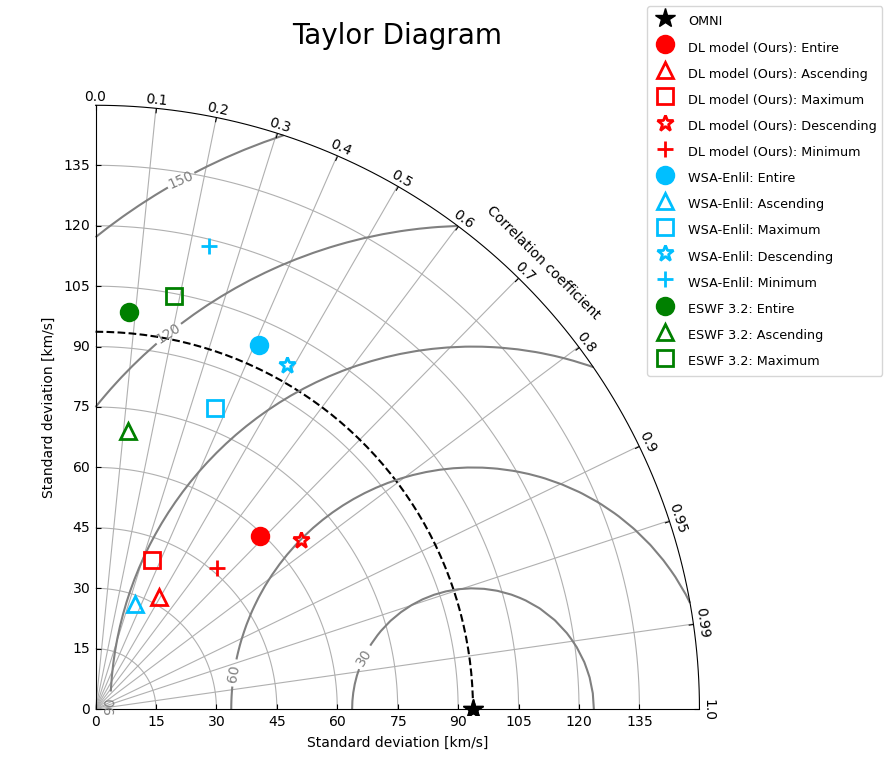

In [10]:
# Taylor Diagram 생성 함수
def create_taylor_diagram():
    # 관측 데이터 (Reference)의 표준편차
    obsSTD = model_taylor_stats['sdev'][0]

    # 모델별 데이터 준비
    datasets = [
        {"stats": model_taylor_stats, "color": "red", "label": "DL model (Ours): Entire", "marker": "o", "fill": True},
        {"stats": model_ascending_taylor_stats, "color": "red", "label": "DL model (Ours): Ascending", "marker": "^"},
        {"stats": model_maximum_taylor_stats, "color": "red", "label": "DL model (Ours): Maximum", "marker": "s"},
        {"stats": model_descending_taylor_stats, "color": "red", "label": "DL model (Ours): Descending", "marker": "*"},
        {"stats": model_minimum_taylor_stats, "color": "red", "label": "DL model (Ours): Minimum", "marker": "+"},

        {"stats": wsa_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Entire", "marker": "o", "fill": True},
        {"stats": wsa_ascending_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Ascending", "marker": "^"},
        {"stats": wsa_maximum_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Maximum", "marker": "s"},
        {"stats": wsa_descending_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Descending", "marker": "*"},
        {"stats": wsa_minimum_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Minimum", "marker": "+"},

        {"stats": eswf_taylor_stats, "color": "green", "label": "ESWF 3.2: Entire", "marker": "o", "fill": True},
        {"stats": eswf_ascending_taylor_stats, "color": "green", "label": "ESWF 3.2: Ascending", "marker": "^"},
        {"stats": eswf_maximum_taylor_stats, "color": "green", "label": "ESWF 3.2: Maximum", "marker": "s"},
        #{"stats": eswf_descending_taylor_stats, "color": "green", "label": "ESWF 3.2: Descending", "marker": "*"},
        #{"stats": eswf_minimum_taylor_stats, "color": "green", "label": "ESWF 3.2: Minimum", "marker": "+"},
    ]

    # Taylor Diagram 생성
    fig = plt.figure(figsize=(10, 8))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label='OMNI')
    #dia = TaylorDiagram(obsSTD, fig=fig, rect=111)

    # Contour 추가
    plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)

    # 각 데이터 포인트 추가
    for data in datasets:
        stats = data["stats"]
        color = data["color"]
        label = data["label"]
        marker = data["marker"]
        fill = data.get("fill", False)

        dia.add_sample(
            stats['sdev'][1],  # 표준편차
            stats['ccoef'][1],  # 상관계수
            label=label,
            marker=marker,
            mec=color,
            mfc=color if fill else 'none',  # 전체 기간은 내부 채우기
            mew=2.0,  # 테두리 두께
            ms=12,  # 마커 크기
        )

    # 범례 추가 (마커 크기 줄이기)
    spl = [p.get_label() for p in dia.samplePoints]
    legend = fig.legend(
        dia.samplePoints,
        spl,
        numpoints=1,
        loc='upper right',  # 오른쪽 상단 위치
        prop=dict(size=9.2),  # 범례 텍스트 크기
        frameon=True,
        handlelength=2,  # 범례 마커 길이
        handleheight=2,  # 범례 마커 높이
    )

    # 범례에서 선 제거
    for handle in legend.legend_handles:
        handle.set_linewidth(0)

    plt.title("Taylor Diagram", fontsize=20, pad=40)

    # 플롯 조정
    plt.rcParams["figure.figsize"] = [10.0, 8.0]  # 플롯 크기를 조금 더 키움
    plt.rcParams['lines.linewidth'] = 2  # 선 두께를 두껍게
    plt.rcParams.update({'font.size': 15})  # 글꼴 크기를 키워 텍스트를 더 잘 보이게

    title_str = "Taylor Diagram"
    save_path = "E:\\research\\SW_Speed_Models_Comparison\\plot_images\\\\{}.png".format(title_str)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save figure
    
    plt.show()


# Taylor Diagram 생성 및 시각화 실행
create_taylor_diagram()

## Sunspot number vs CC

In [11]:
sunspot_ms_path = "E:/research/SW_Speed_Models_Comparison/data/sunspot_number_data/SN_ms_tot_V2.0.txt"
sunspot_m_path = "E:/research/SW_Speed_Models_Comparison/data/sunspot_number_data/SN_m_tot_V2.0.txt"

In [12]:
sorted_by_years = {
    '2012': [2128, 2129, 2130, 2131, 2132], 
    '2013': [2141, 2142, 2143, 2144, 2145], 
    '2014': [2155, 2156, 2157, 2158], 
    '2015': [2168, 2169, 2170, 2171, 2172], 
    '2016': [2182, 2183, 2184, 2185], 
    '2017': [2195, 2196, 2197, 2198, 2199], 
    '2018': [2208, 2209, 2210, 2211, 2212], 
    '2019': [2222, 2223, 2224, 2225], 
    '2020': [2235, 2236, 2237, 2238, 2239]
}

model_year_cc_list = []
wsa_year_cc_list = []
eswf_year_cc_list = []

for year in sorted_by_years:
    omni_dates_oct_dec, omni_speeds_oct_dec = [], []
    model_dates_oct_dec, model_speeds_oct_dec = [], []
    wsa_dates_oct_dec, wsa_speeds_oct_dec = [], []
    eswf_dates_oct_dec, eswf_speeds_oct_dec = [], []
    
    for CR in sorted_by_years[year]:
        omni_dates, omni_speeds = OMNI(CR)
        omni_dates_oct_dec.extend(omni_dates)
        omni_speeds_oct_dec.extend(omni_speeds)

        model_dates, model_speeds = DL_Model(CR)
        model_dates_oct_dec.extend(model_dates)
        model_speeds_oct_dec.extend(model_speeds)

        wsa_dates, wsa_speeds = WSA_ENLIL(CR)
        wsa_dates_oct_dec.extend(wsa_dates)
        wsa_speeds_oct_dec.extend(wsa_speeds)

        eswf_dates, eswf_speeds = ESWF3_2(CR)
        eswf_dates_oct_dec.extend(eswf_dates)
        eswf_speeds_oct_dec.extend(eswf_speeds)

    omni_dates_oct_dec = np.array(omni_dates_oct_dec)
    model_dates_oct_dec = np.array(model_dates_oct_dec) 
    wsa_dates_oct_dec = np.array(wsa_dates_oct_dec)
    eswf_dates_oct_dec = np.array(eswf_dates_oct_dec)

    omni_speeds_oct_dec = np.array(omni_speeds_oct_dec)
    model_speeds_oct_dec = np.array(model_speeds_oct_dec) 
    wsa_speeds_oct_dec = np.array(wsa_speeds_oct_dec)
    eswf_speeds_oct_dec = np.array(eswf_speeds_oct_dec)

    omni_dates_oct_dec_valid, omni_speeds_oct_dec_valid = [], []
    model_dates_oct_dec_valid, model_speeds_oct_dec_valid = [], []
    wsa_dates_oct_dec_valid, wsa_speeds_oct_dec_valid = [], []
    eswf_dates_oct_dec_valid, eswf_speeds_oct_dec_valid = [], []

    valid_index = ~np.isnan(omni_speeds_oct_dec) & ~np.isnan(model_speeds_oct_dec) & ~np.isnan(wsa_speeds_oct_dec) & ~np.isnan(eswf_speeds_oct_dec)

    omni_dates_oct_dec_valid.extend(omni_dates_oct_dec[valid_index])
    omni_speeds_oct_dec_valid.extend(omni_speeds_oct_dec[valid_index])
    model_dates_oct_dec_valid.extend(model_dates_oct_dec[valid_index])
    model_speeds_oct_dec_valid.extend(model_speeds_oct_dec[valid_index])
    wsa_dates_oct_dec_valid.extend(wsa_dates_oct_dec[valid_index])
    wsa_speeds_oct_dec_valid.extend(wsa_speeds_oct_dec[valid_index])
    eswf_dates_oct_dec_valid.extend(eswf_dates_oct_dec[valid_index])
    eswf_speeds_oct_dec_valid.extend(eswf_speeds_oct_dec[valid_index])

    OMNI_valid = []
    model_valid = []
    wsa_valid = []
    eswf_valid = []
    
    for i in range(len(omni_dates_oct_dec_valid)):
        OMNI_valid.append(omni_speeds_oct_dec_valid[i])
        model_valid.append(model_speeds_oct_dec_valid[i])
        wsa_valid.append(wsa_speeds_oct_dec_valid[i])
        eswf_valid.append(eswf_speeds_oct_dec_valid[i])

    model_pcc, _ = pearsonr(OMNI_valid, model_valid)
    wsa_pcc, _ = pearsonr(OMNI_valid, wsa_valid)
    eswf_pcc, _ = pearsonr(OMNI_valid, eswf_valid)


    model_year_cc_list.append(model_pcc)
    wsa_year_cc_list.append(wsa_pcc)
    eswf_year_cc_list.append(eswf_pcc)

    print(np.round(model_pcc, 3))
    print(np.round(wsa_pcc, 3))
    print(np.round(eswf_pcc, 3), '\n')

0.49
0.352
0.117 

0.348
0.182
-0.01 

0.443
0.229
0.023 

0.756
0.454
0.273 

0.862
0.687
-0.154 

0.762
0.386
-0.187 

0.709
0.335
-0.125 

0.702
0.277
0.094 

0.655
0.245
-0.208 



In [13]:
model_month_cc_list = []
wsa_month_cc_list = []
eswf_month_cc_list = []

for i in range(len(model_year_cc_list)):
    for j in range(0, 12):
        if j != 10:
            model_month_cc_list.append(np.nan)
            wsa_month_cc_list.append(np.nan)
            eswf_month_cc_list.append(np.nan)
        else:
            model_month_cc_list.append(model_year_cc_list[i])
            wsa_month_cc_list.append(wsa_year_cc_list[i])
            eswf_month_cc_list.append(eswf_year_cc_list[i])

In [14]:
series = pd.Series(model_month_cc_list)
model_month_cc_list = series.interpolate(method='linear', limit_direction='both')
model_month_cc_list = model_month_cc_list.tolist()

series = pd.Series(wsa_month_cc_list)
wsa_month_cc_list = series.interpolate(method='linear', limit_direction='both')
wsa_month_cc_list = wsa_month_cc_list.tolist()

series = pd.Series(eswf_month_cc_list)
eswf_month_cc_list = series.interpolate(method='linear', limit_direction='both')
eswf_month_cc_list = eswf_month_cc_list.tolist()

In [15]:
date = []
sunspot_num_m = []
sunspot_num_ms = []

with open(sunspot_m_path, 'r') as f:
    for line in f.readlines():
        date.append(datetime.strptime(line[:7], '%Y %m'))
        sunspot_num_m.append(float(line[18:23]))

with open(sunspot_ms_path, 'r') as f:
    for line in f.readlines():
        sunspot_num_ms.append(float(line[18:23]))

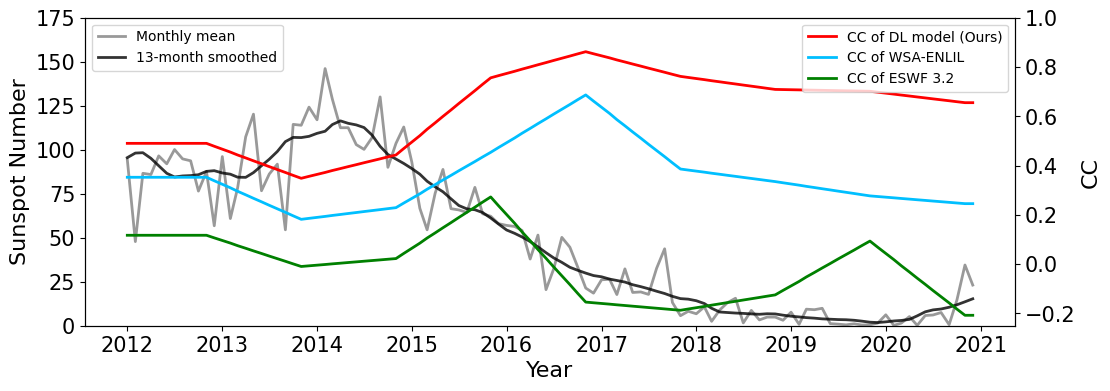

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot(date, sunspot_num_m, c='gray', alpha=0.8, label='Monthly mean')
ax1.plot(date, sunspot_num_ms, c='black', alpha=0.8, label='13-month smoothed')
ax1.set_xlabel("Year", fontsize=16)
ax1.set_ylabel("Sunspot Number", fontsize=16)
ax1.set_ylim(0, 175)
ax1.legend(loc='upper left', fontsize=10)

ax2 = ax1.twinx()
ax2.plot(date, model_month_cc_list, c='red', label='CC of DL model (Ours)')
ax2.plot(date, wsa_month_cc_list, c='deepskyblue', label='CC of WSA-ENLIL')
ax2.plot(date, eswf_month_cc_list, c='green', label='CC of ESWF 3.2')
ax2.set_ylabel("CC", fontsize=16)
ax2.set_ylim(-0.25, 1)
ax2.legend(loc='upper right', fontsize=10)

title_str = "Sunspot Number vs CC (models)"
save_path = "E:\\research\\SW_Speed_Models_Comparison\\plot_images\\\\{}.png".format(title_str)
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save figure

plt.show()